# Experimentos Comparativos

In [4]:
!pip install matplotlib pandas seaborn numpy

     ---------------------------------------- 0.0/164.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/164.2 kB ? eta -:--:--
     -- ------------------------------------- 10.2/164.2 kB ? eta -:--:--
     --------- --------------------------- 41.0/164.2 kB 487.6 kB/s eta 0:00:01
     ---------------- -------------------- 71.7/164.2 kB 558.5 kB/s eta 0:00:01
     -------------------- ---------------- 92.2/164.2 kB 581.0 kB/s eta 0:00:01
     ---------------------- ------------- 102.4/164.2 kB 535.8 kB/s eta 0:00:01
     ------------------------------- ---- 143.4/164.2 kB 566.5 kB/s eta 0:00:01
     ------------------------------------ 164.2/164.2 kB 546.0 kB/s eta 0:00:00
  Using cached pillow-10.3.0-cp311-cp311-win_amd64.whl.metadata (9.4 kB)
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.0 MB 1.3 MB/s eta 0:00:07
   ---------------------------------------- 0.0/8.0 MB 653.6 kB/s eta 0:00:13
   -

In [5]:
from matplotlib import pyplot as plt
import pandas as pd
import subprocess
import os

CPU_EXEC = "../build/src/MyProjectCPU"
CL_EXEC = "../build/src/cl/MyProjectCL"
CUDA_EXEC = "../build/src/cuda/MyProjectCUDA"

### Análisis

In [6]:
cpu = pd.read_csv("nbody_naive_cpu.csv", header=None)

naive_cl = pd.read_csv("nbody_naive_cl.csv", header=None)
local_mem_cl = pd.read_csv("nbody_local_mem_cl.csv", header=None)
bidimensional_cl = pd.read_csv("nbody_bidimensional_cl.csv", header=None)
naive_cuda = pd.read_csv("nbody_naive_cuda.csv", header=None)
local_mem_cuda = pd.read_csv("nbody_local_mem_cuda.csv", header=None)
bidimensional_cuda = pd.read_csv("nbody_bidimensional_cuda.csv", header=None)

cpu.columns = ["size", "data creation time", "execution time", "total time"]

cl_columns = ["size", "local size", "global size", "local size y", "global size y", "local mem size", "create data time", "copy to device", "execution time", "copy to host"]
naive_cl.columns = cl_columns
local_mem_cl.columns = cl_columns
bidimensional_cl.columns = cl_columns

cuda_columns = ["size", "block size", "grid size", "create data time", "copy to device", "execution time", "copy to host","total time"]
naive_cuda.columns = cuda_columns
local_mem_cuda.columns = cuda_columns
bidimensional_cuda.columns = ["size", "block size", "block size y", "grid size", "grid size y", "create data time", "copy to device", "execution time", "copy to host","total time"]

naive_cl["total time"] = naive_cl["create data time"] + naive_cl["copy to device"] + naive_cl["execution time"] + naive_cl["copy to host"]
local_mem_cl["total time"] = local_mem_cl["create data time"] + local_mem_cl["copy to device"] + local_mem_cl["execution time"] + local_mem_cl["copy to host"]
bidimensional_cl["total time"] = bidimensional_cl["create data time"] + bidimensional_cl["copy to device"] + bidimensional_cl["execution time"] + bidimensional_cl["copy to host"]

# cuda.columns = ["size", "block size", "grid size", "data creation time", "copy to device time", "execution time", "copy to host time", "total time"]

Gráfico de aumento de velocidad de las versiones paralelas respecto a la versión secuencial de la implementación:

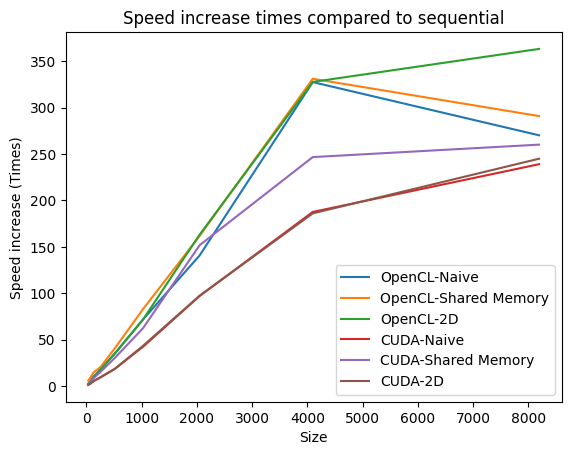

In [27]:
# plot avg total time for each size
naive_cl["tps"] = naive_cl["size"]*naive_cl["size"]*100/naive_cl["total time"]
local_mem_cl["tps"] = local_mem_cl["size"]*local_mem_cl["size"]*100/local_mem_cl["total time"]
bidimensional_cl["tps"] = bidimensional_cl["size"]*bidimensional_cl["size"]*100/bidimensional_cl["total time"]
naive_cuda["tps"] = naive_cuda["size"]*naive_cuda["size"]*100/naive_cuda["total time"]
local_mem_cuda["tps"] = local_mem_cuda["size"]*local_mem_cuda["size"]*100/local_mem_cuda["total time"]
bidimensional_cuda["tps"] = bidimensional_cuda["size"]*bidimensional_cuda["size"]*100/bidimensional_cuda["total time"]

cpu_avg = cpu.groupby("size").mean()
naive_cl_avg = naive_cl.groupby("size").mean()
local_mem_cl_avg = local_mem_cl.groupby("size").mean()
bidimensional_cl_avg = bidimensional_cl.groupby("size").mean()
naive_cuda_avg = naive_cuda.groupby("size").mean()
local_mem_cuda_avg = local_mem_cuda.groupby("size").mean()
bidimensional_cuda_avg = bidimensional_cuda.groupby("size").mean()

naive_cl_times = cpu_avg/naive_cl_avg
local_mem_cl_times = cpu_avg/local_mem_cl_avg
bidimensional_cl_times = cpu_avg/bidimensional_cl_avg
naive_cuda_times = cpu_avg/naive_cuda_avg
local_mem_cuda_times = cpu_avg/local_mem_cuda_avg
bidimensional_cuda_times = cpu_avg/bidimensional_cuda_avg
# cuda_avg = cuda.groupby("size").mean()

fig, ax = plt.subplots()
#ax.plot(cpu_avg.index, cpu_avg["total time"], label="CPU")
ax.plot(naive_cl_times.index, naive_cl_times["total time"], label="OpenCL-Naive")
ax.plot(local_mem_cl_times.index, local_mem_cl_times["total time"], label="OpenCL-Shared Memory")
ax.plot(bidimensional_cl_times.index, bidimensional_cl_times["total time"], label="OpenCL-2D")
ax.plot(naive_cuda_times.index, naive_cuda_times["total time"], label="CUDA-Naive")
ax.plot(local_mem_cuda_times.index, local_mem_cuda_times["total time"], label="CUDA-Shared Memory")
ax.plot(bidimensional_cuda_times.index, bidimensional_cuda_times["total time"], label="CUDA-2D")
# ax.plot(cuda_avg.index, cuda_avg["total time"], label="CUDA")
ax.set_xlabel("Size")
ax.set_ylabel("Speed increase (Times)")
ax.legend()
plt.title("Speed increase times compared to sequential")
plt.show()

Podemos ver que el aumento de velocidad tiene un crecimiento lineal hasta que se llega a un conteo de 4096 partículas, donde el crecimiento se estanca respecto a la implementación secuencial, donde ya no se obtiene mejores resultados.
## Operaciones de partículas por segundo
El siguiente gráfico muestra la cantidad de operaciónes entre partículas que se realizan en cada prueba, el cálculo se realizó tomando el número de combinaciones de particulas disponibles (el tamaño del arreglo al cuadrado) por el número de iteraciónes realizadas,  este número es dividido por el tiempo de ejecución para calcular cuántos de estos cálculos se realizan por microsegundo. 

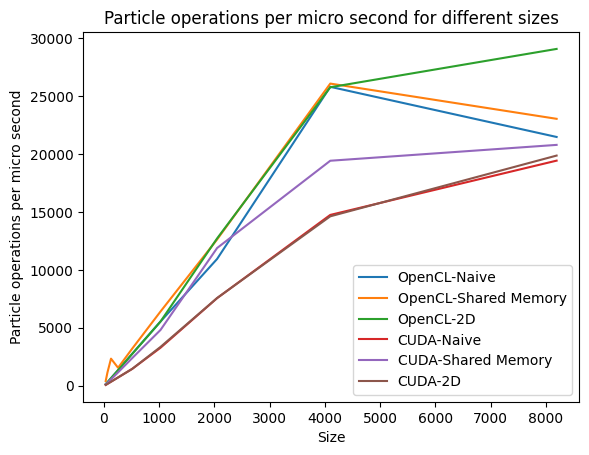

In [28]:
# plot avg execution time for each size
fig, ax = plt.subplots()
ax.plot(naive_cl_avg.index, naive_cl_avg["tps"], label="OpenCL-Naive")
ax.plot(local_mem_cl_avg.index, local_mem_cl_avg["tps"], label="OpenCL-Shared Memory")
ax.plot(bidimensional_cl_avg.index, bidimensional_cl_avg["tps"], label="OpenCL-2D")
ax.plot(naive_cuda_avg.index, naive_cuda_avg["tps"], label="CUDA-Naive")
ax.plot(local_mem_cuda_avg.index, local_mem_cuda_avg["tps"], label="CUDA-Shared Memory")
ax.plot(bidimensional_cuda_avg.index, bidimensional_cuda_avg["tps"], label="CUDA-2D")
# ax.plot(cuda_avg.index, cuda_avg["execution time"], label="CUDA")
ax.set_xlabel("Size")
ax.set_ylabel("Particle operations per micro second")
ax.legend()
plt.title("Particle operations per micro second for different sizes")
plt.show()

Podemos ver que tenemos en forma un gráfico similar al anterior, pero con otros valores, podemos comprobar que para los resultados obtenidos vemos una limitación en la cantidad de operaciones que podemos realizar en por microsegundo, lo que nos limitará el speedup que podemos conseguir por este medio con el equipo actual.

Finalmente observamos los speedups conseguidos de manera numerica

In [32]:
# print speedup on execution time
speedup_naive_cl = cpu_avg["execution time"] / naive_cl_avg["execution time"]
speedup_shared_cl = cpu_avg["execution time"] / local_mem_cl_avg["execution time"]
speedup_bidimensional_cl = cpu_avg["execution time"] / bidimensional_cl_avg["execution time"]
speedup_naive_cuda = cpu_avg["execution time"] / naive_cuda_avg["execution time"]
speedup_shared_cuda = cpu_avg["execution time"] / local_mem_cuda_avg["execution time"]
speedup_bidimensional_cuda = cpu_avg["execution time"] / bidimensional_cuda_avg["execution time"]
# speedup_cuda = cpu_avg["execution time"] / cuda_avg["execution time"]

print("Speedup Naive OpenCL")
print(speedup_naive_cl)
print("Speedup Shared Memory OpenCL")
print(speedup_shared_cl)
print("Speedup Bidimensional Mapping OpenCL")
print(speedup_bidimensional_cl)
print("Speedup Naive CUDA")
print(speedup_naive_cuda)
print("Speedup Shared Memory CUDA")
print(speedup_shared_cuda)
print("Speedup Bidimensional Mapping CUDA")
print(speedup_bidimensional_cuda)

Speedup Naive OpenCL
size
32        2.985270
64        5.058224
128      10.867755
256      18.872460
512      36.163391
1024     73.638838
2048    143.501190
4096    333.036560
8192    272.960121
Name: execution time, dtype: float64
Speedup Shared Memory OpenCL
size
32       13.378208
64       11.181562
128      16.550270
256      21.944431
512      42.152340
1024     85.273082
2048    165.382046
4096    337.027893
8192    294.319923
Name: execution time, dtype: float64
Speedup Bidimensional Mapping OpenCL
size
32        3.019203
64        5.046651
128      10.789838
256      18.779497
512      36.055842
1024     73.542930
2048    166.684969
4096    334.294616
8192    366.940042
Name: execution time, dtype: float64
Speedup Naive CUDA
size
32        1.312872
64        2.435332
128       5.413611
256       9.635184
512      18.639112
1024     42.807881
2048     97.999323
4096    189.199166
8192    240.272403
Name: execution time, dtype: float64
Speedup Shared Memory CUDA
size
32        